In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read shot data on FC Barcelona
shots = pd.read_csv('../data/input/shots.csv')

In [3]:
shots.head()

,season,match_date,period,timestamp,team,player,play_pattern,under_pressure,body_part,type,...,first_time,one_on_one,open_goal,key_pass_id,start_location_x,start_location_y,distance,angle,goal,statsbomb_xg
0,2004/2005,2004-12-11,1,00:01:21.354,Barcelona,Andrés Iniesta Luján,Regular Play,0,Foot,Open Play,...,0,1,0,NaN,112.4,51.6,13.867949,19.025606,1,0.216037
1,2004/2005,2004-12-11,1,00:18:01.782,Barcelona,"Samuel Eto""o Fils",From Counter,0,Foot,Open Play,...,0,0,0,7422812b-baf5-4b0c-b031-60c5b46af2e5,114.4,59.1,19.904020,6.720854,0,0.019257
2,2004/2005,2004-12-11,1,00:27:39.854,Barcelona,Rafael Márquez Álvarez,From Free Kick,0,Foot,Open Play,...,1,0,0,52b7356b-94b1-40ef-9de3-5b015011ac77,115.1,31.7,9.638465,27.010346,0,0.166539
3,2004/2005,2004-12-11,1,00:41:13.993,Barcelona,Xavier Hernández Creus,From Free Kick,0,Foot,Open Play,...,1,0,0,NaN,93.4,39.9,26.600188,17.103428,0,0.017750
4,2004/2005,2004-12-11,1,00:41:53.356,Barcelona,Anderson Luís de Souza,From Keeper,0,Foot,Open Play,...,0,0,0,e3ab31a8-bdd8-4846-9483-e25f05c802f7,96.5,49.4,25.310275,16.751155,0,0.043860


In [4]:
# print a summary of shot data
print("==============================")
print(f"shots : info")
print("==============================")
shots.info()

shots : info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7225 entries, 0 to 7224
Data columns (total 21 columns):
season              7225 non-null object
match_date          7225 non-null object
period              7225 non-null int64
timestamp           7225 non-null object
team                7225 non-null object
player              7225 non-null object
play_pattern        7225 non-null object
under_pressure      7225 non-null int64
body_part           7225 non-null object
type                7225 non-null object
technique           7225 non-null object
first_time          7225 non-null int64
one_on_one          7225 non-null int64
open_goal           7225 non-null int64
key_pass_id         5183 non-null object
start_location_x    7225 non-null float64
start_location_y    7225 non-null float64
distance            7225 non-null float64
angle               7225 non-null float64
goal                7225 non-null int64
statsbomb_xg        7225 non-null float64
dtypes: float64(5), 

In [5]:
# select features
cat_features =  ['play_pattern', 'under_pressure', 'body_part', 'type', 'technique', 'first_time', 'one_on_one', 'open_goal'] # カテゴリカル変数
num_features = ['distance', 'angle'] # 連続変数

In [6]:
# split into features and label
X = shots.loc[:, cat_features + num_features]
y = shots['goal']

In [7]:
from category_encoders import OrdinalEncoder

# encodes categorical features as ordered feature
oe = OrdinalEncoder(cols=cat_features)
X = oe.fit_transform(X)

In [8]:
# train-test splitting
num_test = len(shots[shots['season']=='2018/2019']) # number of 18/19 season data
# train: 04/05 - 16/17 season
X_train = X.iloc[:-num_test]
y_train = y.iloc[:-num_test]
# test: 18/19 season
X_test = X.iloc[-num_test:]
y_test = y.iloc[-num_test:]

In [9]:
import lightgbm as lgbm
from sklearn.model_selection import GridSearchCV

# define LightGBM model
lightgbm = lgbm.LGBMClassifier(objective='binary', random_state=0)

# candidates of parameter values
params = {
          'num_leaves': [10, 31, 50, 70],
          'max_depth': [3, 5, 7, 9],
          'min_child_weight': [1, 2, 3, 4, 5],
          'reg_alpha': [0, 1, 10, 100],
          'reg_lambda': [0, 1, 10, 100], 
          }

# grid searching
gscv = GridSearchCV(estimator=lightgbm, 
                    param_grid=params, 
                    scoring='neg_log_loss',
                    cv=5, 
                    n_jobs=-1,
                    verbose=2,
                    )
gscv.fit(X_train, y_train)

# print results
print('best parameters', gscv.best_params_)
print('best log loss:', gscv.best_score_)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 207 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 613 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1179 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 1909 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2799 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 3853 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 5067 tasks      | elapsed:   49.8s


best parameters {'max_depth': 3, 'min_child_weight': 2, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 10}
best log loss: -0.3615977432125434


[Parallel(n_jobs=-1)]: Done 6377 out of 6400 | elapsed:  1.1min remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 6400 out of 6400 | elapsed:  1.1min finished


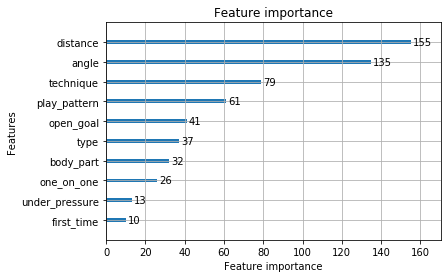

In [10]:
# plot feature importance
lgbm.plot_importance(gscv.best_estimator_)

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

# cross validation

# initizalize lists contain the results
val_scores = np.zeros((3, 5))
val_diffs = np.zeros((3, 5))
test_scores = np.zeros((3, 5))
test_diffs = np.zeros((3, 5))
y_test_preds = np.zeros((3, 5, len(X_test))) 

# define Stratified KFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    X_train2 = X_train.iloc[train_idx]
    X_val = X_train.iloc[val_idx]
    y_train2 = y_train.iloc[train_idx]
    y_val = y_train.iloc[val_idx]

    print('Fold {}'.format(fold + 1))
    
    # LightGBM
    lightgbm = lgbm.LGBMClassifier(
                                   objective='binary', 
                                   n_estimators=10000,
                                   random_state=0,
                                   **gscv.best_params_,
                                   )
    lightgbm.fit(X_train2, y_train2,
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=20,
                      verbose=-1,
                      ) 
    
    y_val_pred = lightgbm.predict_proba(X_val)[:, 1]
    y_test_pred = lightgbm.predict_proba(X_test)[:, 1]
    val_scores[0, fold] = log_loss(y_val, y_val_pred)
    test_scores[0, fold] = log_loss(y_test, y_test_pred)
    val_diffs[0, fold] = np.sum(y_val_pred) - np.sum(y_val)
    test_diffs[0, fold] = np.sum(y_test_pred) - np.sum(y_test)
    y_test_preds[0, fold] = y_test_pred

    # isotonic calibration
    isotonic = CalibratedClassifierCV(lightgbm, cv='prefit', method='isotonic')
    isotonic.fit(X_val, y_val)
    
    y_val_pred = isotonic.predict_proba(X_val)[:, 1]
    y_test_pred = isotonic.predict_proba(X_test)[:, 1]
    val_scores[1, fold] = log_loss(y_val, y_val_pred)
    test_scores[1, fold] = log_loss(y_test, y_test_pred)
    val_diffs[1, fold] = np.sum(y_val_pred) - np.sum(y_val)
    test_diffs[1, fold] = np.sum(y_test_pred) - np.sum(y_test)
    y_test_preds[1, fold] = y_test_pred

    # sigmoid calibration
    sigmoid = CalibratedClassifierCV(lightgbm, cv='prefit', method='sigmoid')
    sigmoid.fit(X_val, y_val)
    
    y_val_pred = sigmoid.predict_proba(X_val)[:, 1]
    y_test_pred = sigmoid.predict_proba(X_test)[:, 1]
    val_scores[2, fold] = log_loss(y_val, y_val_pred)
    test_scores[2, fold] = log_loss(y_test, y_test_pred)
    val_diffs[2, fold] = np.sum(y_val_pred) - np.sum(y_val)
    test_diffs[2, fold] = np.sum(y_test_pred) - np.sum(y_test)
    y_test_preds[2, fold] = y_test_pred
    print()

# compute the average values between folds
val_scores = np.mean(val_scores, axis=1)
val_diffs = np.mean(val_diffs, axis=1)
test_scores = np.mean(test_scores, axis=1)
test_diffs = np.mean(test_diffs, axis=1)
y_test_preds = np.mean(y_test_preds, axis=1)

# model names
model_names = ['LightGBM',
               'LightGBM + Isotonic',
               'LightGBM + Sigmoid',
               ]

# print the validation resuls 
for i, model_name in enumerate(model_names): 
    print(model_name)
    print('\tlog loss: {:.3f}'.format(val_scores[i]))
    print('\tgoal diff: {:.3f}\n'.format(val_diffs[i]))

Fold 1
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_logloss: 0.381716

Fold 2
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.365958

Fold 3
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.344967

Fold 4
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.371393

Fold 5
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[153]	valid_0's binary_logloss: 0.344077

LightGBM
	log loss: 0.362
	goal diff: -0.134

LightGBM + Isotonic
	log loss: 0.349
	goal diff: -0.000

LightGBM + Sigmoid
	log loss: 0.365
	goal diff: 0.007



In [12]:
# specify the model for use 
model_num = 1 # LightGBM + Isotonic
test_score = test_scores[model_num]
test_diff = test_diffs[model_num]
xg = y_test_preds[model_num] 

log loss: 0.406
goal diff: 1.640


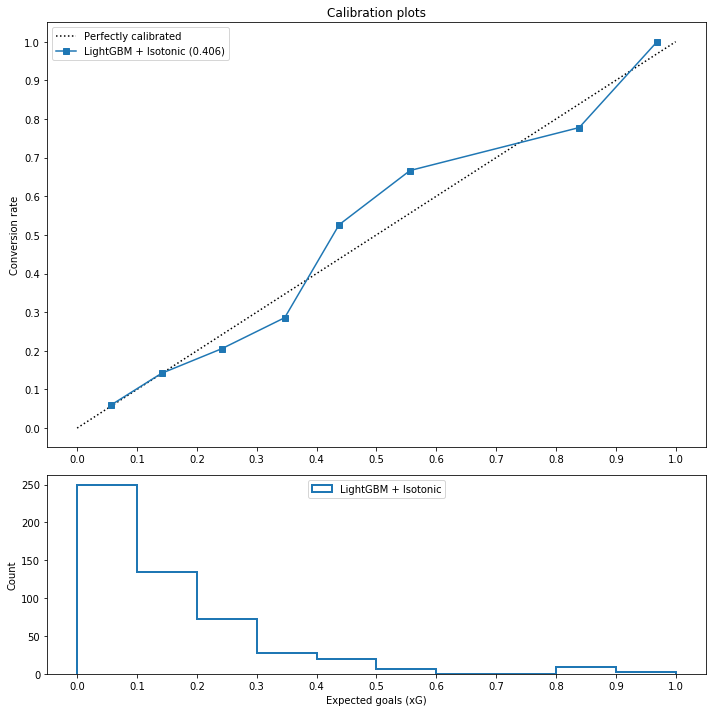

In [13]:
from sklearn.calibration import calibration_curve

# test

# print the test results
print('log loss: {:.3f}'.format(test_score))
print('goal diff: {:.3f}'.format(test_diff))

# plot calibration curve and histgram
fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')

fraction_of_positives, mean_predicted_value = calibration_curve(y_test, xg, n_bins=10)

ax1.plot(mean_predicted_value, fraction_of_positives, 's-', label='{} ({:.3f})'.format(model_names[model_num], test_score))

ax1.set_ylabel("Conversion rate")
ax1.set_ylim([-0.05, 1.05])
ax1.set_xticks(np.linspace(0, 1, 11))
ax1.set_yticks(np.linspace(0, 1, 11))
ax1.legend(loc="upper left")
ax1.set_title('Calibration plots')

n, bins, patches = ax2.hist(xg, range=(0, 1), bins=10, label=model_names[model_num], histtype='step', lw=2)
ax2.set_xlabel("Expected goals (xG)")
ax2.set_ylabel("Count")
ax2.set_xticks(np.linspace(0, 1, 11))
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

In [14]:
# print summary statistics of xG
pd.Series(xg).describe()

count    521.000000
mean       0.156699
std        0.154541
min        0.008964
25%        0.059202
50%        0.106956
75%        0.208359
max        0.980000
dtype: float64

In [15]:
# add the 'xg' column to 18/19 season data
shots_1819 = shots.iloc[-num_test:].copy()
shots_1819['xg'] = xg

In [16]:
# compare actual goals with the sum of xg or of statsbomb_xg
round(shots_1819.loc[:, ['goal', 'xg', 'statsbomb_xg']].sum(), 2)

goal            80.00
xg              81.64
statsbomb_xg    69.50
dtype: float64

In [17]:
# write shot data with xG values to csv file
shots_1819.to_csv('../data/output/shots_1819.csv', index=False, encoding='utf-8')